In [2]:
#import
import os
import sys

import tqdm
import math
import torch
import logging

import numpy as np
import pandas as pd
import torch.nn as nn
import lightning.pytorch as pl
import matplotlib.pyplot as plt

from scipy import spatial
from scipy.stats import chisquare, kstest
from scipy.optimize import curve_fit
from torchmetrics import MeanAbsoluteError
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint

In [3]:
data_path = './data/clasdb_pi_plus_n.txt'
df = pd.read_csv(data_path, delimiter='\t', header=None)
df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
df.loc[8314:65671, 'Ebeam'] = 5.754  # peculiarity of this dataset.
df = df[~((df.Ebeam == 5.754) & (~df.Q2.isin([1.715, 2.050, 2.445, 2.915, 3.480, 4.155])))] # peculiarity of this dataset #2
df['phi'] = df.phi.apply(lambda x: math.radians(x))
df['weight'] = df['error'].apply(lambda x: x and 1 / x or 100)  # x and 1 / x or 100  is just a reversed error but with validation 1/0 error in this case it will return 100
df = df.drop('id', axis=1)
df = df.drop_duplicates(subset=['Ebeam', 'W', 'Q2', 'cos_theta', 'phi'])

In [23]:
df

,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,weight,rel_error
0,1.515,1.11,0.3,0.991445,0.261799,15.3700,5.264366,0.189956,2.919630
1,1.515,1.11,0.3,0.991445,0.785398,4.5110,1.743136,0.573679,2.587865
2,1.515,1.11,0.3,0.991445,1.308997,4.4780,1.611260,0.620632,2.779191
3,1.515,1.11,0.3,0.991445,1.832596,5.1360,1.523529,0.656371,3.371120
4,1.515,1.11,0.3,0.991445,2.356194,5.0780,1.219442,0.820047,4.164199
...,...,...,...,...,...,...,...,...,...
98022,5.499,2.01,4.0,0.975000,3.730641,0.1012,0.043165,23.166714,2.344471
98023,5.499,2.01,4.0,0.975000,3.992441,0.1199,0.076638,13.048361,1.564498
98024,5.499,2.01,4.0,0.975000,4.646939,0.1578,0.095391,10.483159,1.654243
98025,5.499,2.01,4.0,0.975000,4.777839,0.2346,0.158557,6.306878,1.479594


In [6]:
df["Ebeam"].value_counts(1)

Ebeam
5.754    0.503843
5.499    0.394727
1.515    0.101430
Name: proportion, dtype: float64

Ebeam
1.515    Axes(0.125,0.11;0.775x0.77)
5.499    Axes(0.125,0.11;0.775x0.77)
5.754    Axes(0.125,0.11;0.775x0.77)
Name: error, dtype: object

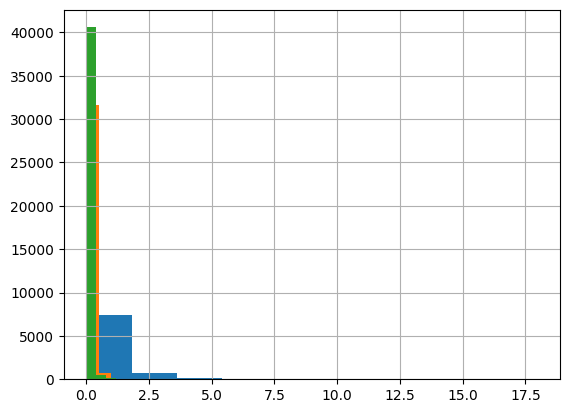

In [10]:
df.groupby('Ebeam').error.hist()

In [16]:
df['rel_error'] = df.dsigma_dOmega/df.error

Ebeam
1.515    Axes(0.125,0.11;0.775x0.77)
5.499    Axes(0.125,0.11;0.775x0.77)
5.754    Axes(0.125,0.11;0.775x0.77)
Name: rel_error, dtype: object

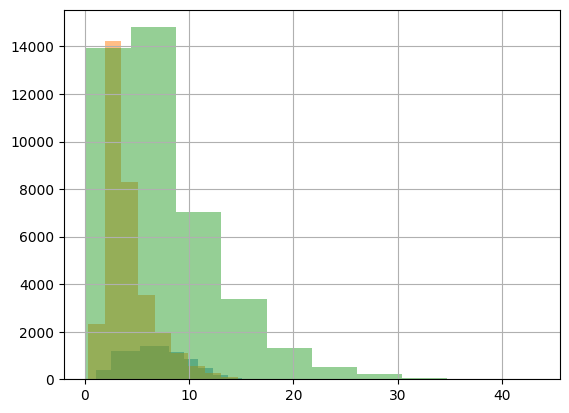

In [18]:
df.groupby('Ebeam').rel_error.hist(alpha=0.5)

<Axes: >

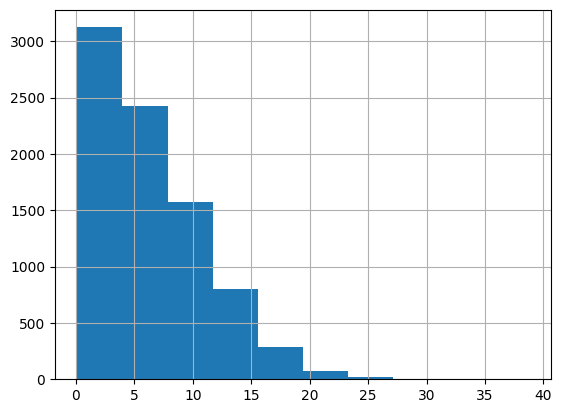

In [24]:
df[df.Ebeam==1.515].rel_error.hist()

In [14]:
df[df.Ebeam==1.515]

,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,weight
0,1.515,1.11,0.3,0.991445,0.261799,15.3700,5.264366,0.189956
1,1.515,1.11,0.3,0.991445,0.785398,4.5110,1.743136,0.573679
2,1.515,1.11,0.3,0.991445,1.308997,4.4780,1.611260,0.620632
3,1.515,1.11,0.3,0.991445,1.832596,5.1360,1.523529,0.656371
4,1.515,1.11,0.3,0.991445,2.356194,5.0780,1.219442,0.820047
...,...,...,...,...,...,...,...,...
8309,1.515,1.41,0.6,-0.130526,4.974188,2.3410,1.024539,0.976049
8310,1.515,1.41,0.6,-0.382683,2.879793,1.2020,0.499456,2.002177
8311,1.515,1.41,0.6,-0.382683,3.403392,0.7774,0.357092,2.800396
8312,1.515,1.41,0.6,-0.382683,4.450590,1.8440,0.586092,1.706216


Ebeam
1.515    Axes(0.125,0.11;0.775x0.77)
5.499    Axes(0.125,0.11;0.775x0.77)
5.754    Axes(0.125,0.11;0.775x0.77)
Name: dsigma_dOmega, dtype: object

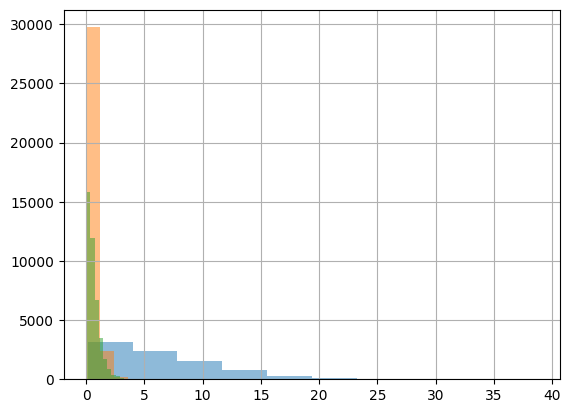

In [25]:
df.groupby('Ebeam').dsigma_dOmega.hist(alpha=0.5)

Ebeam
1.515    Axes(0.125,0.11;0.775x0.77)
5.499    Axes(0.125,0.11;0.775x0.77)
5.754    Axes(0.125,0.11;0.775x0.77)
Name: dsigma_dOmega, dtype: object

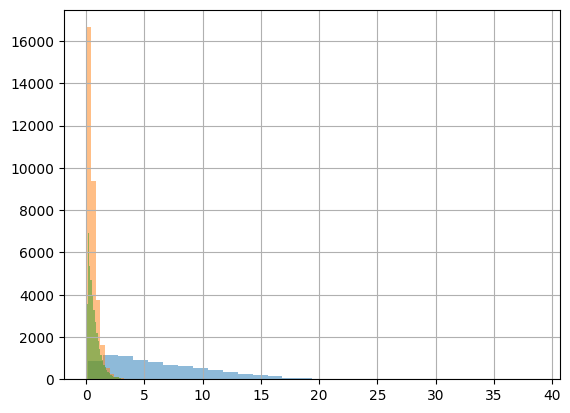

In [26]:
df.groupby('Ebeam').dsigma_dOmega.hist(bins=30, alpha=0.5)

In [28]:
df.error.mean()

np.float64(0.20925764795173893)